# Impot libraries #

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Define files to read #

## Parcelles ##

In [2]:
file_NPCS = "../data/NPCS_CAD_TPR_PARV_S.shp"
file_MOVD = "../data/MOVD_CAD_TPR_PARV_S.shp"

## Base map ##

In [3]:
file_lakes = "../data/MN95_OIT_TPR_LAD_GEN_LAC.shp"
file_highways = "../data/autoroutes.shp"
file_communes_geom = '../data/MN95_CAD_TPR_LAD_COM_S.shp'

## Other data ##

In [4]:
file_communes = '../data/communes_vd.csv'

# Load parcelles data #

In [5]:
parcelles_NPCS = gpd.read_file(file_NPCS)
parcelles_MOVD = gpd.read_file(file_MOVD)

## Merge parcelles dataframe ##

In [6]:
parcelles = pd.concat([parcelles_NPCS, parcelles_MOVD])
parcelles.reset_index(drop=True, inplace=True)

## Add column for  'no_com_can' ##

In [7]:
# new column 'no_com_can' based from 'IDENTDN' remove extra char
parcelles['no_com_can'] = parcelles['IDENTDN'].str[3:6].str.lstrip('0')

### check data ###

In [8]:
len(parcelles)

59467

In [9]:
parcelles.head(3)

,NUMERO,IDEX2000,VALIDITE_T,VALIDITE,EGRIS_EGRI,ID,SHAPE_LEN,INTEGRALIT,IDENTDN,SUPERFICIE,SHAPE_AREA,GENRE_TXT,GENRE,geometry,no_com_can
0,395,188000395,oui,0,CH875779973676,4667951,331.053892,complet,VD0188000000,None,5416.416482,parcelle privée,0,"POLYGON ((2520785.144 1152586.504, 2520799.374...",188
1,391,188000391,oui,0,CH155083924553,4667892,708.502347,complet,VD0188000000,None,28477.592318,parcelle privée,0,"POLYGON ((2520834.171 1152876.256, 2520876.733...",188
2,DP 1082,188101082,oui,0,CH733679579889,4668475,120.546197,complet,VD0188000000,None,252.620991,DP communal,1,"POLYGON ((2520997.048 1152956.177, 2521002.725...",188


<AxesSubplot:>

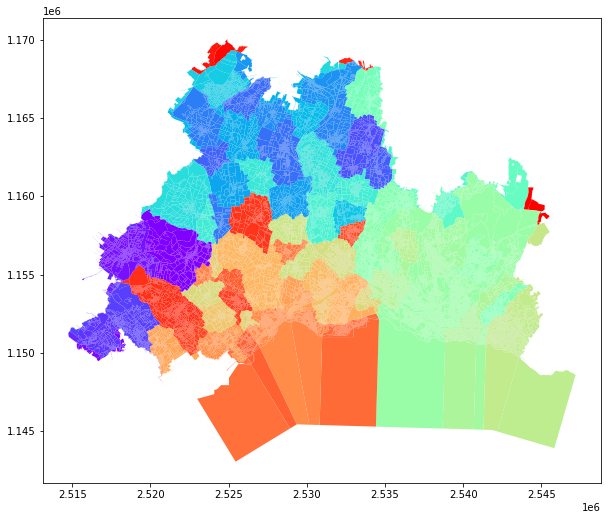

In [10]:
parcelles.plot('IDENTDN', figsize=(10,10), cmap='rainbow')

# Load commune data #

In [11]:
communes_data = pd.read_csv(file_communes)
# cleanup
communes_data = communes_data.drop(['GEOMETRY'], axis=1)

### Check data ##

In [12]:
communes_data.head(3)

,ogc_fid,no_com_can,no_com_fed,nom_min,nom_maj,no_dis_can,no_dis_fed,no_canton,perimetre
0,1,102,5535,Saint-Barthélemy (VD),SAINT-BARTHÉLEMY (VD),3,2223,22,NaN
1,2,336,5861,Rolle,ROLLE,8,2228,22,NaN
2,3,381,5932,Ursins,URSINS,4,2224,22,NaN


# Create geodataframe #

## Get geometries ##

In [13]:
communes_geom = gpd.read_file(file_communes_geom)
communes_geom = communes_geom.rename(str.lower, axis='columns')

## Create final geodataframe ##

In [14]:
communes = gpd.GeoDataFrame()
communes['geometry'] = None

In [15]:
communes_geom = communes_geom['geometry']

In [16]:
communes = gpd.GeoDataFrame(communes_data, geometry=communes_geom)

### check data ###

In [17]:
communes.head(3)

,ogc_fid,no_com_can,no_com_fed,nom_min,nom_maj,no_dis_can,no_dis_fed,no_canton,perimetre,geometry
0,1,102,5535,Saint-Barthélemy (VD),SAINT-BARTHÉLEMY (VD),3,2223,22,NaN,"POLYGON ((2536799.038 1166156.651, 2536797.628..."
1,2,336,5861,Rolle,ROLLE,8,2228,22,NaN,"POLYGON ((2513913.773 1144416.026, 2513999.465..."
2,3,381,5932,Ursins,URSINS,4,2224,22,NaN,"POLYGON ((2541753.782 1177514.664, 2541835.857..."


# Plot all #

## Extract data for layers ##

In [18]:
perim1 = communes.loc[communes['perimetre']==1]
perim2 = communes.loc[communes['perimetre']==2]
lakes = gpd.read_file(file_lakes)
highways = gpd.read_file(file_highways)

<AxesSubplot:>

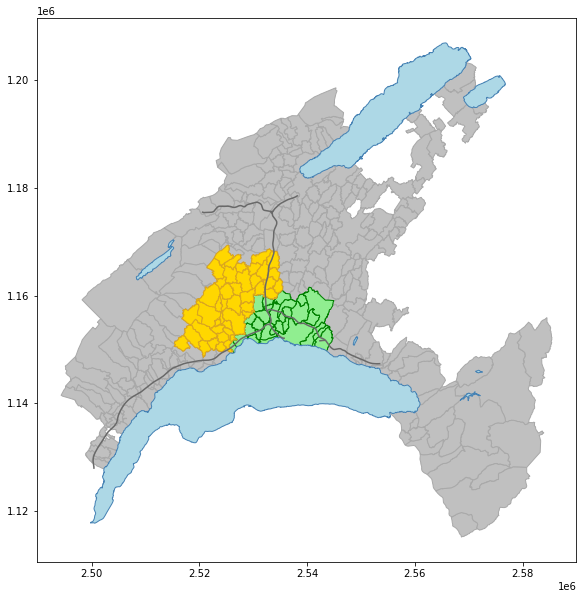

In [19]:
fig, ax = plt.subplots(figsize=(10,10))
communes.plot(ax=ax, facecolor='silver', edgecolor='darkgrey')
perim1.plot(ax=ax, facecolor='lightgreen', edgecolor='green')
perim2.plot(ax=ax, facecolor='gold', edgecolor='goldenrod')
lakes.plot(ax=ax, facecolor='lightblue', edgecolor='steelblue')
highways.plot(ax=ax, facecolor='none', edgecolor='dimgrey')

# Analyze data #

## Create buffer ##

In [20]:
buffer_1000 = highways.buffer(1000).unary_union

### check data ###

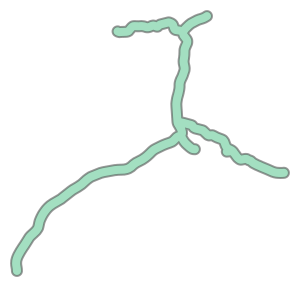

In [21]:
buffer_1000

## Select parcelles intersects buffer ##

In [22]:
parcelles_intersected = parcelles[parcelles.intersects(buffer_1000)]

### check data ###

<AxesSubplot:>

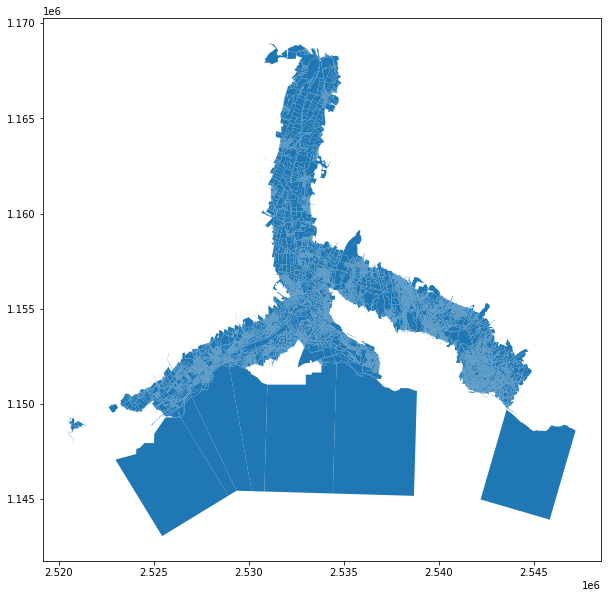

In [23]:
parcelles_intersected.plot(figsize=(10,10))

## Create perimetres ##

In [24]:
perimetres = communes.dissolve(by='perimetre', aggfunc='first')
perimetres.reset_index(level=0, inplace=True)
perimetres = perimetres[['perimetre', 'geometry']]
p1 = perimetres.loc[0].geometry
p2 = perimetres.loc[1].geometry

### check data ###

In [25]:
perimetres

,perimetre,geometry
0,1.0,"POLYGON ((2544168.774 1154207.477, 2544187.424..."
1,2.0,"POLYGON ((2515445.197 1150908.340, 2515386.619..."


<AxesSubplot:>

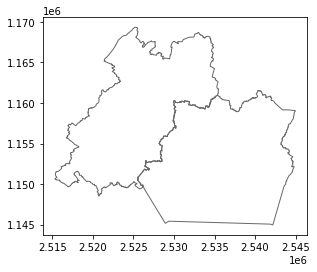

In [26]:
perimetres.plot(facecolor='none', edgecolor='dimgrey')

## Select parcelles intersects buffer and in P1 ##

In [27]:
parcelles_intersected_p1 = parcelles_intersected[parcelles_intersected.intersects(p1)]

<AxesSubplot:>

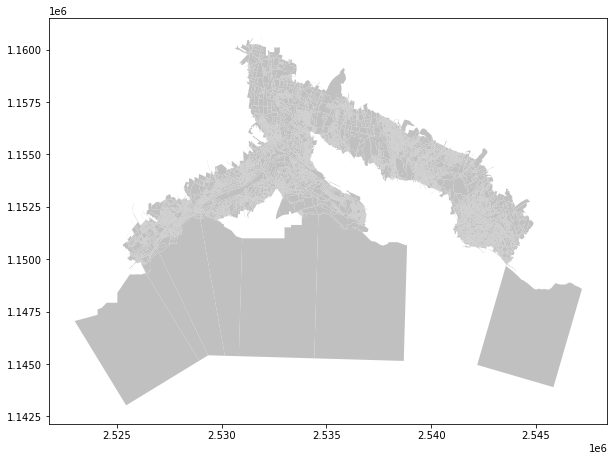

In [28]:
parcelles_intersected_p1.plot(figsize=(10,10), facecolor='silver')

In [29]:
len(parcelles_intersected_p1)

18105

# Parcelles Confédération #

In [30]:
file_parcelles_conf_pot = '../data/parcelles_conf_pot.csv'
parcelles_conf_pot = pd.read_csv(file_parcelles_conf_pot)

In [31]:
parcelles_conf_pot_id = parcelles_conf_pot['IDEX2000']

In [32]:
listToStr = ', '.join([str(elem) for elem in parcelles_conf_pot])

In [33]:
parcelles_conf_pot = parcelles[parcelles['IDEX2000'].isin(parcelles_conf_pot_id)]

<AxesSubplot:>

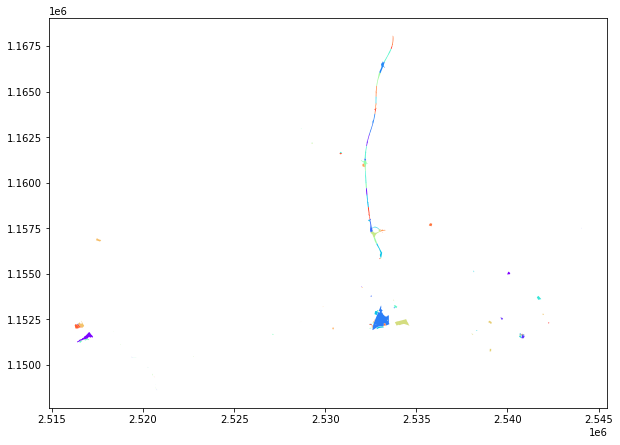

In [38]:
parcelles_conf_pot.plot(figsize=(10,10), cmap='rainbow')